In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tsai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 272 kB 15.2 MB/s 
     |████████████████████████████████| 2.5 MB 65.8 MB/s 


In [3]:
from tsai.all import *

In [4]:
my_setup()

os              : Linux-5.10.133+-x86_64-with-glibc2.27
python          : 3.8.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.12.1+cu113
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : [14.75] GB


# Data Preprocessing

## Import and Concat Patients

In [5]:
import os.path as path

In [6]:
SPECIFIC_COLUMNS = []
columns = ['ECG', 'SC']


print(SPECIFIC_COLUMNS)



[]


In [13]:
SPECIFIC_TASK = [1,2,3,4]
# SPECIFIC_COLUMNS = []

columns = ['timestamp', 'LTA', 'RTA', 'IO', 'ECG', 'RGS', 'accel_x1', 'accel_y1', 'accel_z1', 'gyro_x1', 'gyro_y1', 'gyro_z1', 'NC1', 'accel_x2', 'accel_y2', 'accel_z2', 'gyro_x2', 'gyro_y2', 'gyro_z2', 'NC2', 'accel_x3', 'accel_y3', 'accel_z3', 'gyro_x3', 'gyro_y3', 'gyro_z3', 'NC3', 'accel_x4', 'accel_y4', 'accel_z4', 'gyro_x4', 'gyro_y4', 'gyro_z4', 'SC', 'label']
if not(SPECIFIC_COLUMNS):
  SPECIFIC_COLUMNS = columns

X_raw=[]
Y_raw=[]
row_count=0
for j in range(1,5):
  # if j in SPECIFIC_TASK or not(SPECIFIC_TASK):
  print(f'Task {j}')
  for i in range(1,13):
    print(f'Patient {i}')
    path_format1=f"/content/drive/MyDrive/without_header/00{i}_task_{j}.txt"
    path_format2=f"/content/drive/MyDrive/without_header/0{i}_task_{j}.txt"
    if path.isfile(path_format1) or path.isfile(path_format2):
      if i <= 9:
        task = pd.read_csv(path_format1, delimiter=',', names=columns).drop(columns=['timestamp'])#[SPECIFIC_COLUMNS]
      else:
        task = pd.read_csv(path_format2, delimiter=',', names=columns).drop(columns=['timestamp'])#[SPECIFIC_COLUMNS]
      task.insert(loc=1, column="Task", value=j)
      row_count+=task.shape[0]
      print(row_count)
      if i == 1:
        Y_raw=task.pop('label').to_numpy()
        X_raw=task.to_numpy()
      else:
        Y_raw=np.concatenate((Y_raw,task.pop('label').to_numpy()))
        X_raw=np.concatenate((X_raw,task.to_numpy()))
  # else: print(f'Skipped Task {j}')
print(X_raw.shape)
print(Y_raw.shape)

Task 1
Patient 1
180501
Patient 2
302002
Patient 3
945503
Patient 4
1039504
Patient 5
1161505
Patient 6
1388506
Patient 7
1537007
Patient 8
1755508
Patient 9
1854509
Patient 10
2256510
Patient 11
2551011
Patient 12
2810512
Task 2
Patient 1
2976513
Patient 2
3096014
Patient 3
3411515
Patient 4
3591516
Patient 5
3602017
Patient 6
3839518
Patient 7
3983019
Patient 8
4166520
Patient 9
4285521
Patient 10
4607522
Patient 11
4834023
Patient 12
4873024
Task 3
Patient 1
4887525
Patient 2
4900526
Patient 3
4938527
Patient 4
4952028
Patient 5
4963029
Patient 6
4996030
Patient 7
5021031
Patient 8
5046032
Patient 9
5187033
Patient 10
5227034
Patient 11
5260035
Patient 12
5293536
Task 4
Patient 1
5309037
Patient 2
5323538
Patient 3
5361039
Patient 4
5377040
Patient 5
5386541
Patient 6
5419542
Patient 7
5445543
Patient 8
5459544
Patient 9
5471045
Patient 10
5510546
Patient 11
5537047
Patient 12
5724048
(430512, 34)
(430512,)


In [8]:
np.mean(Y_raw)

0.45169705733332577

In [9]:
len(X_raw)/50

56210.24

## Batch Data

In [52]:
BATCH_SIZE=250
n_batches=len(X_raw)//BATCH_SIZE 
# remove remainder rows
X_no_remain=X_raw[:n_batches*BATCH_SIZE,]
Y_no_remain=Y_raw[:n_batches*BATCH_SIZE]

X_batch = np.split(X_no_remain, n_batches)
Y_batch = np.split(Y_no_remain, n_batches)

In [53]:
# for i in Y_batch:
#   print(np.mean(i))

In [54]:
# n_samples=BATCH_SIZE
# n_features=X.shape[1]
# n_steps=n_batches

# X=np.reshape(X_batch, (n_samples, n_features, n_steps))
# X.shape

In [55]:
n_samples=n_batches
n_features=X_raw.shape[1]
n_steps=BATCH_SIZE

X=np.reshape(X_batch, (n_samples, n_features, n_steps))
X.shape

(1722, 34, 250)

In [56]:
THRESHOLD=0.5
Y=[]
for i,batch in enumerate(Y_batch):
  batch_mean=np.mean(batch)
  if batch_mean > THRESHOLD:
    Y.append(1)
  else:
    Y.append(0)
Y=np.array(Y)
Y.shape

(1722,)

In [57]:
np.mean(Y)

0.3983739837398374

# Begin TSAI Setup and Training

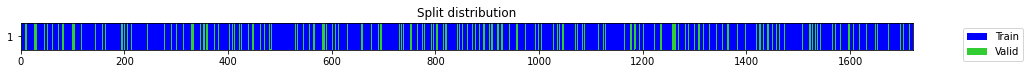

((#1378) [1098,367,1718,368,1161,417,25,1478,788,240...],
 (#344) [943,101,1698,1464,1185,1292,129,164,1297,697...])

In [58]:
splits = get_splits(Y, valid_size=.2, stratify=True, shuffle=True)
splits

In [59]:
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, Y, tfms=tfms, splits=splits, inplace=True)

In [60]:
# dsets.train

In [61]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=[TSStandardize()], num_workers=0)

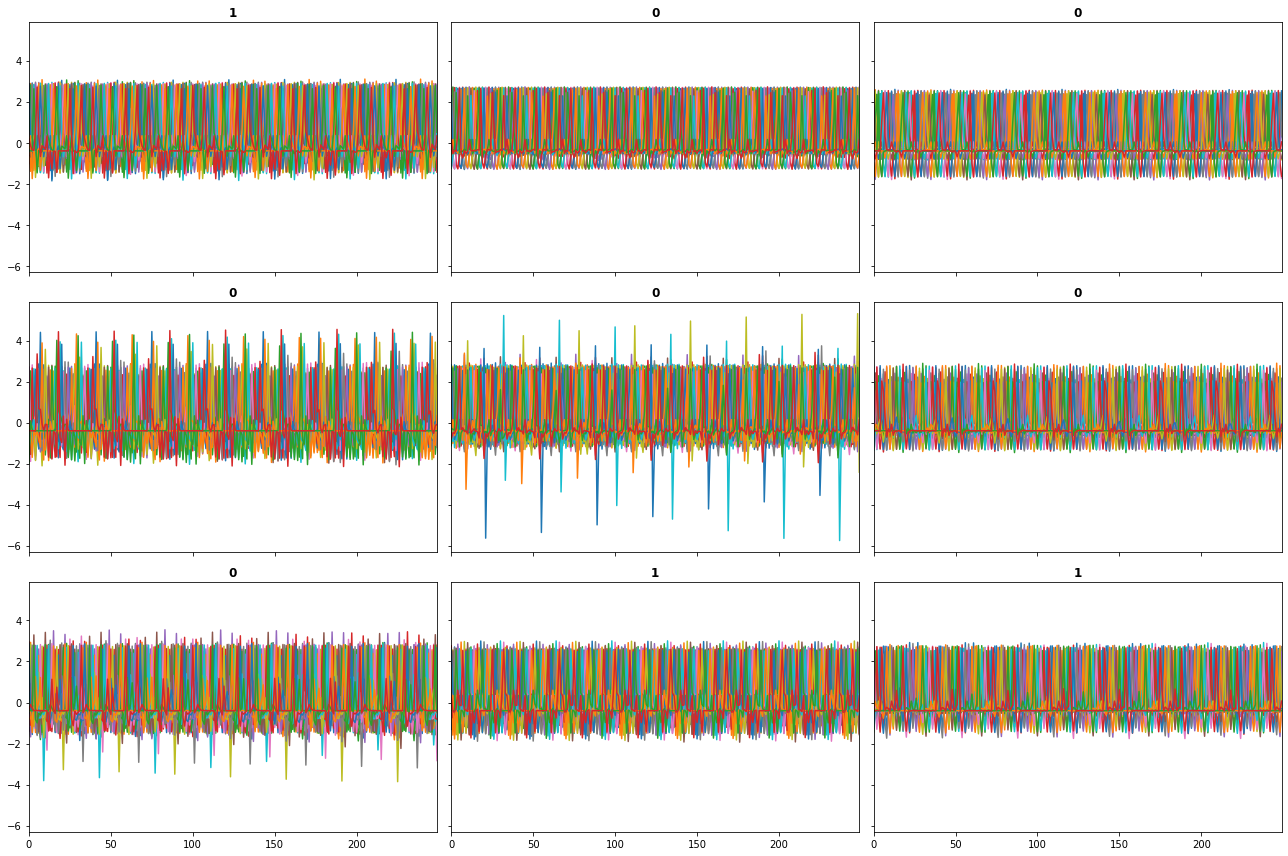

In [62]:
dls.show_batch(sharey=True)

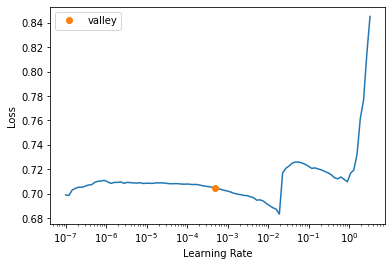

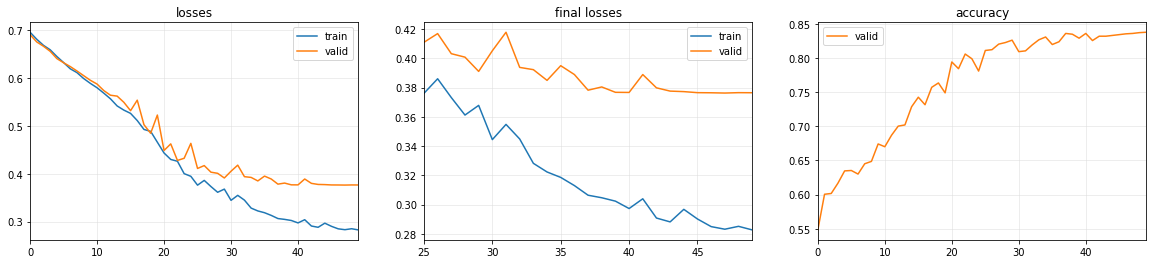

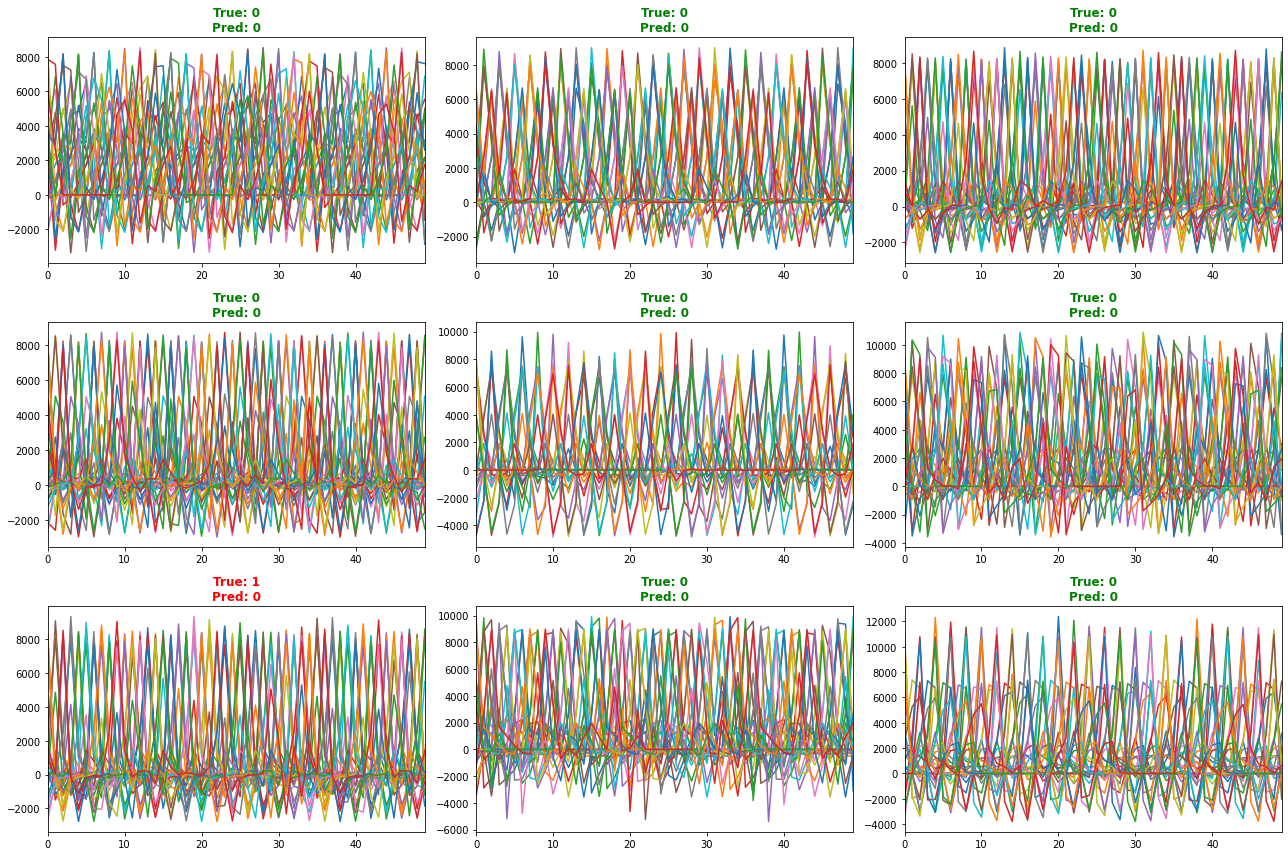

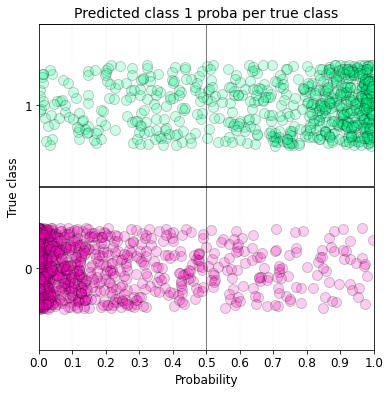

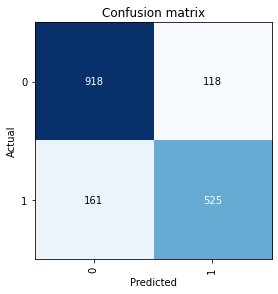

In [47]:
model = LSTM(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('LSTM-init')

learn.load('LSTM-init')
x = learn.lr_find()

learn.fit_one_cycle(50, lr_max=x)
learn.save('LSTM')
learn.recorder.plot_metrics()
learn.show_results()
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

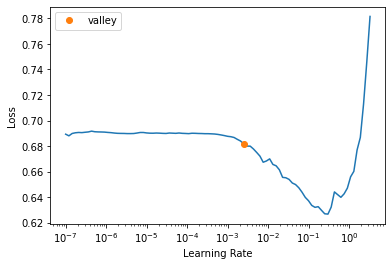

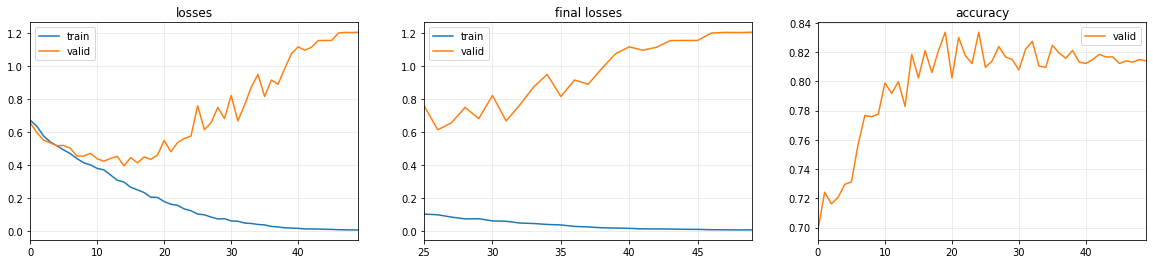

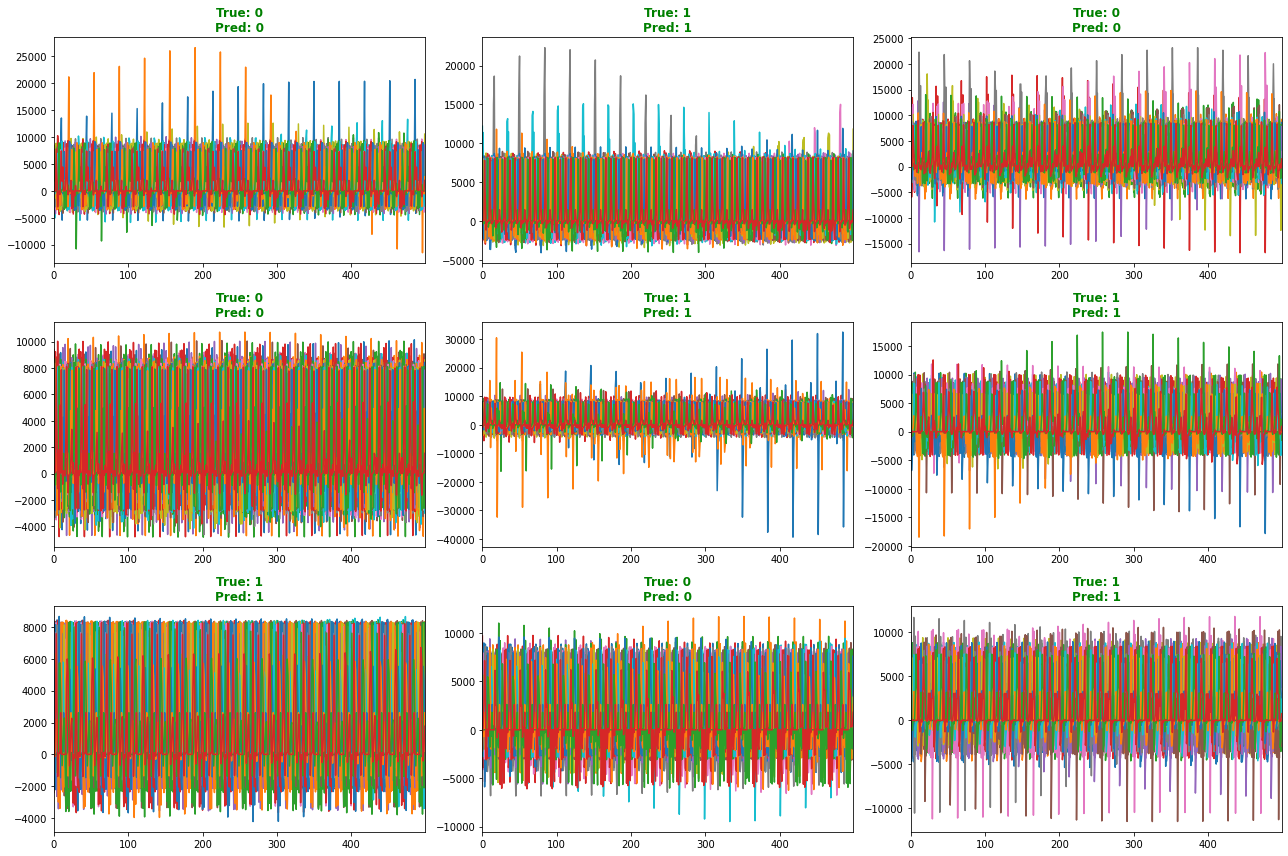

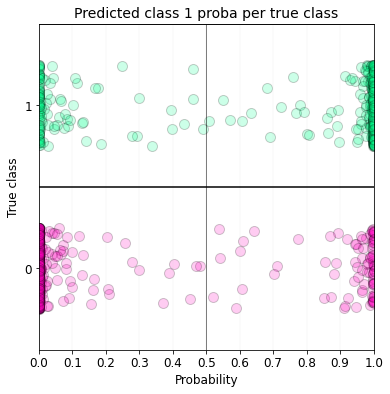

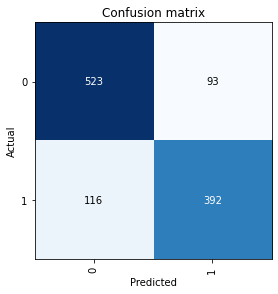

In [ ]:
model = LSTM(dls.vars, dls.c, rnn_dropout=0.60)
learn = Learner(dls, model, metrics=accuracy)
learn.save('LSTM-Dropout-init')

learn.load('LSTM-Dropout-init')
x = learn.lr_find()

learn.fit_one_cycle(50, lr_max=x)
learn.save('LSTM-Dropout')
learn.recorder.plot_metrics()
learn.show_results()
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

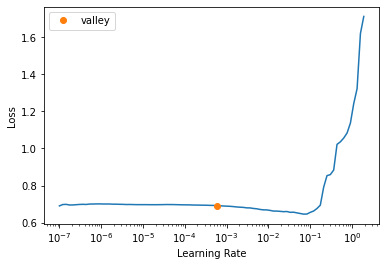

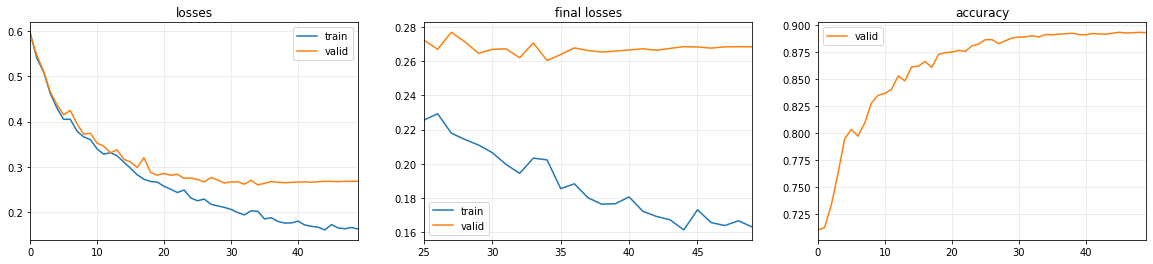

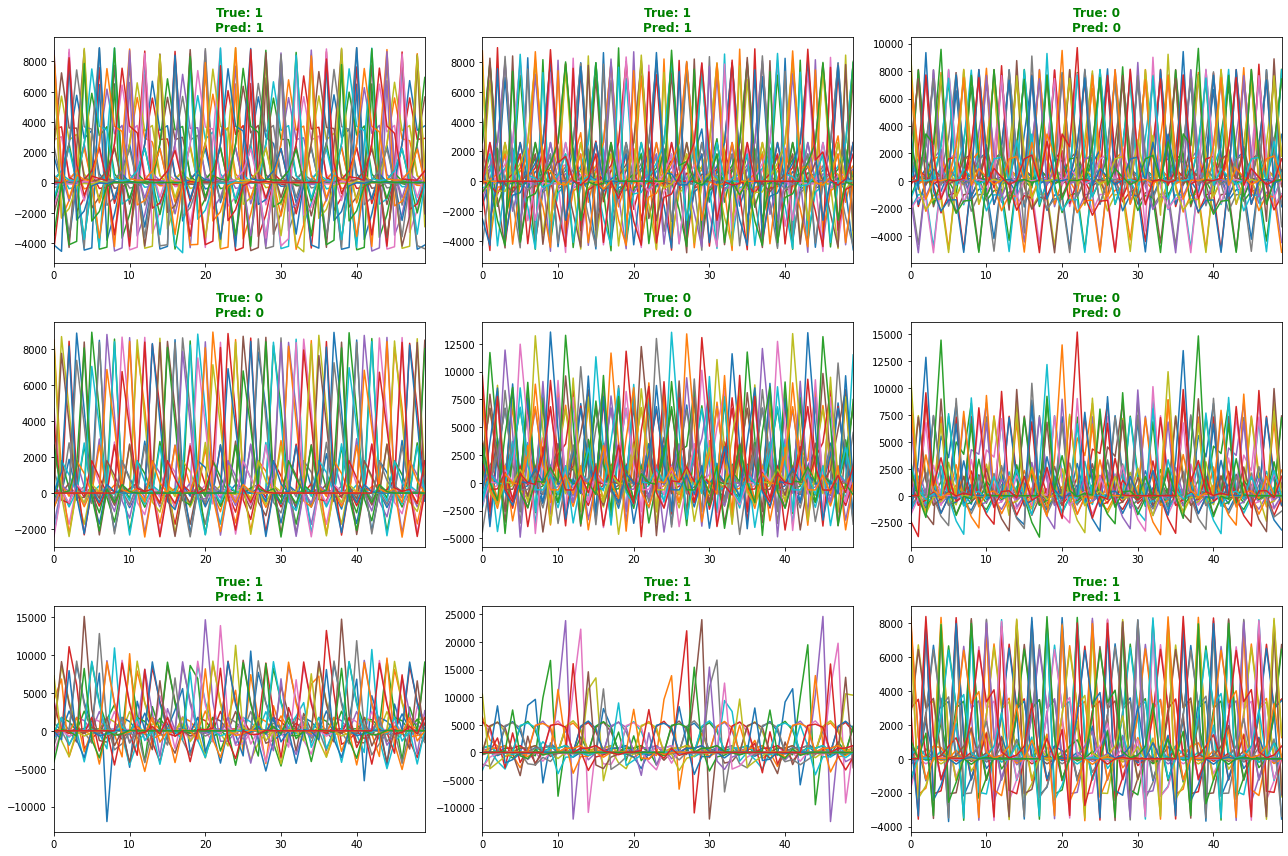

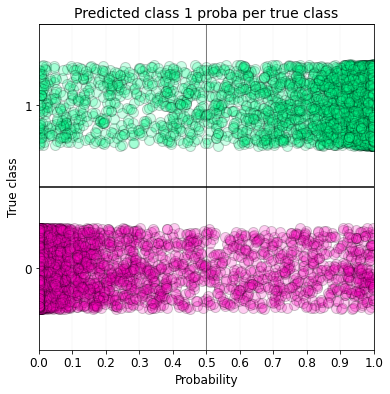

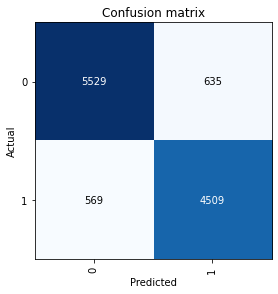

In [ ]:
model = GRU(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('GRU-init')

learn.load('GRU-init')
x = learn.lr_find()

learn.fit_one_cycle(50, lr_max=x)
learn.save('LSTM-Dropout')
learn.recorder.plot_metrics()
learn.show_results()
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

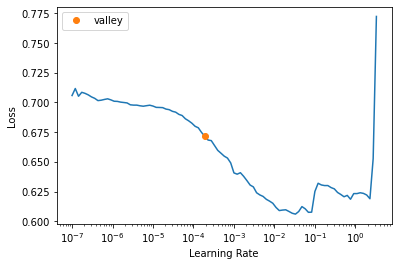

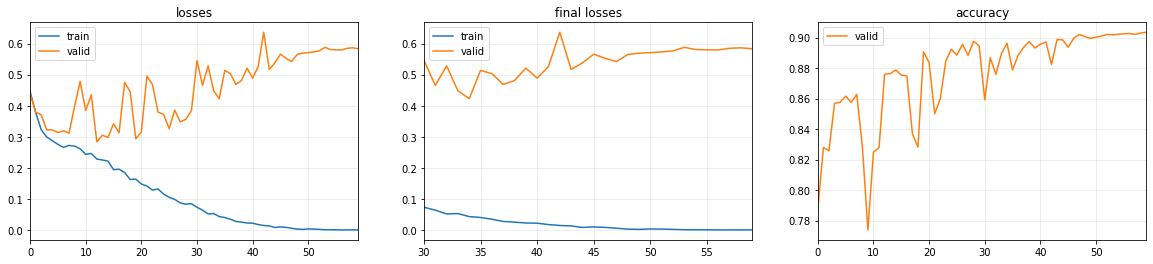

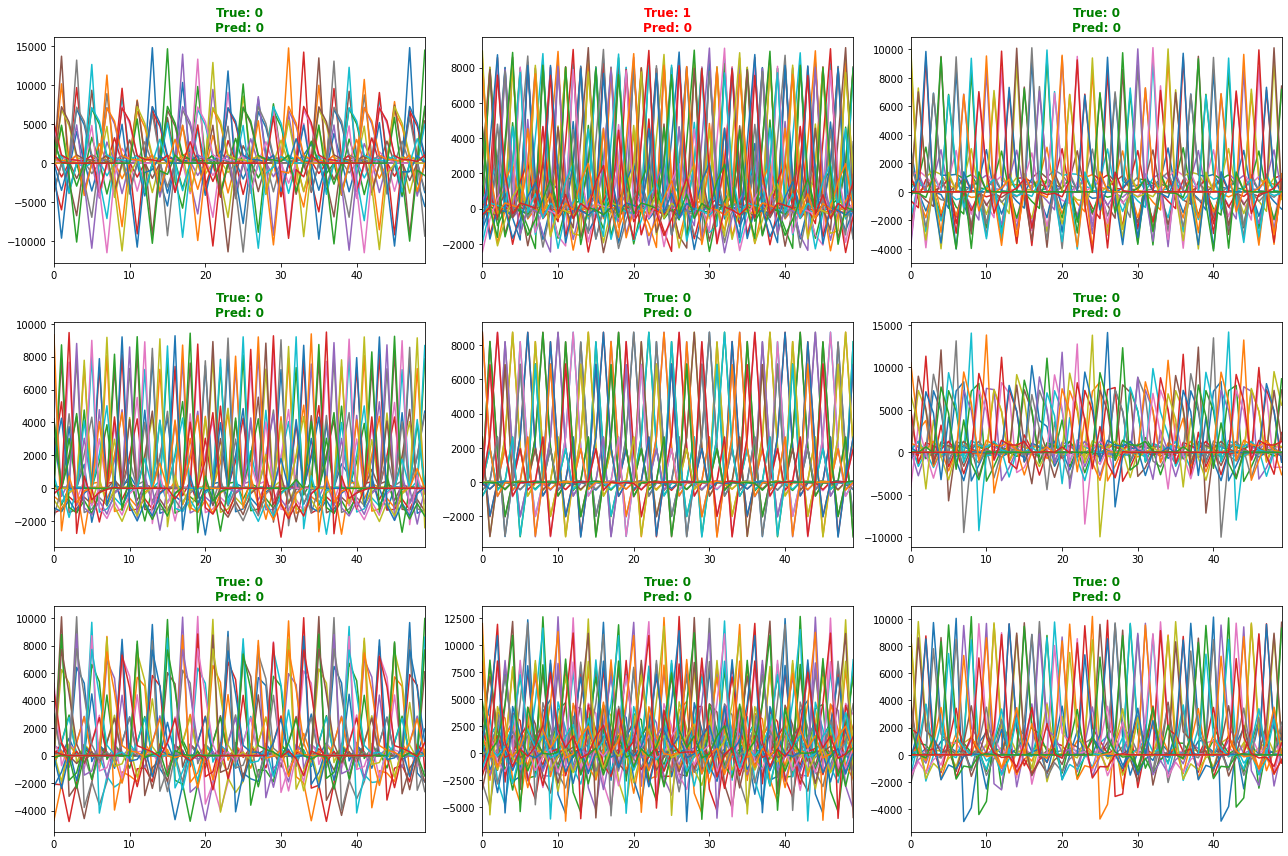

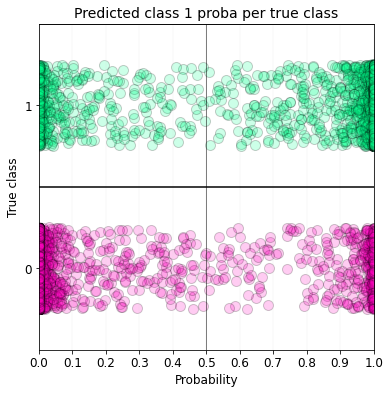

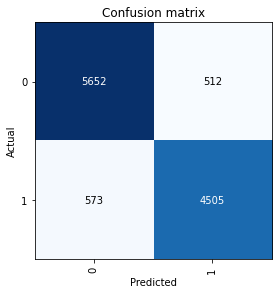

In [ ]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('InceptionTime-init')

learn.load('InceptionTime-init')
x = learn.lr_find()

learn.fit_one_cycle(60, lr_max=x)
learn.save('InceptionTime')
learn.recorder.plot_metrics()
learn.show_results()
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

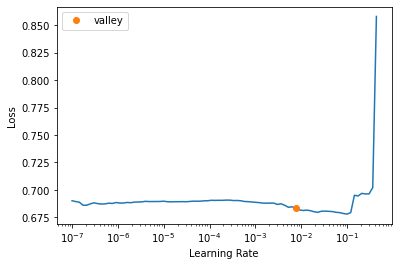

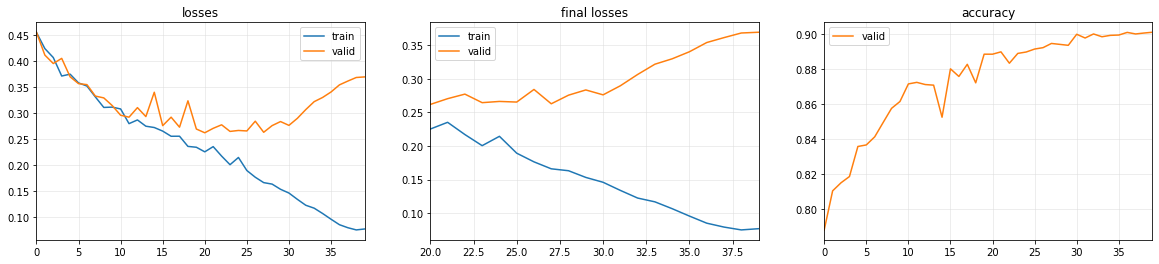

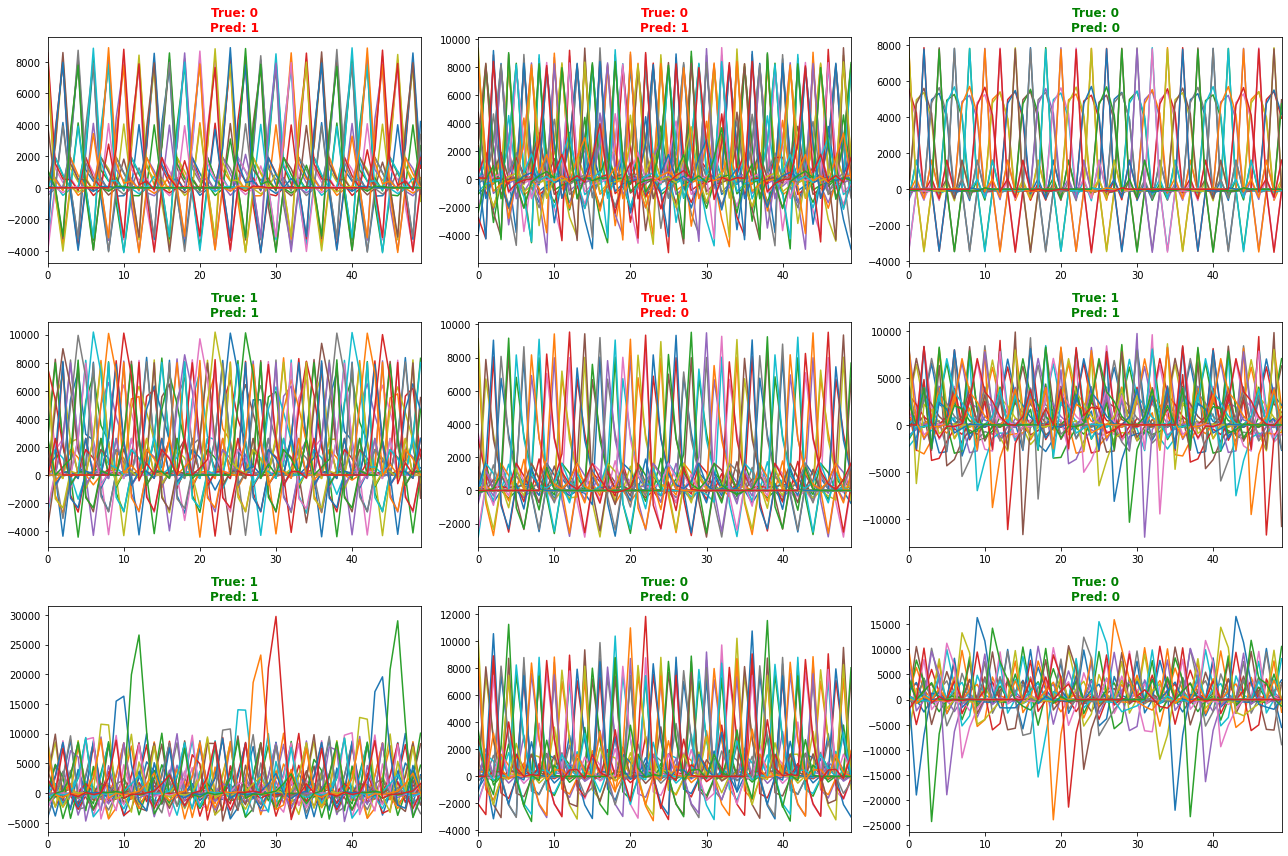

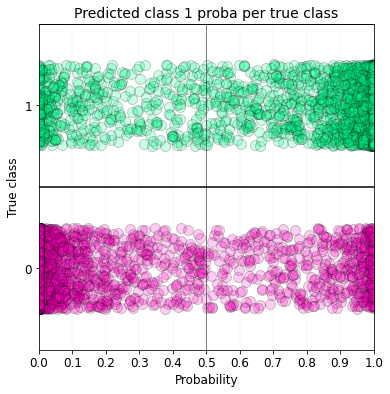

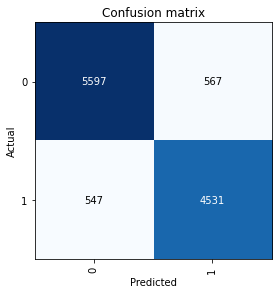

In [ ]:
model = TCN(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('TCN-init')

learn.load('TCN-init')
x = learn.lr_find()

learn.fit_one_cycle(40, lr_max=x)
learn.save('TCN')
learn.recorder.plot_metrics()
learn.show_results()
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Inference

## Import Data

In [ ]:
columns = ['timestamp', 'LTA', 'RTA', 'IO', 'ECG', 'RGS', 'accel_x1', 'accel_y1', 'accel_z1', 'gyro_x1', 'gyro_y1', 'gyro_z1', 'NC1', 'accel_x2', 'accel_y2', 'accel_z2', 'gyro_x2', 'gyro_y2', 'gyro_z2', 'NC2', 'accel_x3', 'accel_y3', 'accel_z3', 'gyro_x3', 'gyro_y3', 'gyro_z3', 'NC3', 'accel_x4', 'accel_y4', 'accel_z4', 'gyro_x4', 'gyro_y4', 'gyro_z4', 'SC', 'label']

task1=pd.read_csv('/content/001_task_1.txt', delimiter=',', names=columns).drop(columns=['timestamp']).head(94000)
Y1=task1.pop('label').to_numpy()
X1=task1.to_numpy()

task2=pd.read_csv('/content/002_task_1.txt', delimiter=',', names=columns).drop(columns=['timestamp']).head(94000)
Y2=task2.pop('label').to_numpy()
X2=task2.to_numpy()

task3=pd.read_csv('/content/003_task_1.txt', delimiter=',', names=columns).drop(columns=['timestamp']).head(94000)
Y3=task3.pop('label').to_numpy()
X3=task3.to_numpy()

task4=pd.read_csv('/content/004_task_1.txt', delimiter=',', names=columns).drop(columns=['timestamp']).head(94000)
Y4=task4.pop('label').to_numpy()
X4=task4.to_numpy()

task5=pd.read_csv('/content/005_task_1.txt', delimiter=',', names=columns).drop(columns=['timestamp']).head(94000)
Y5=task5.pop('label').to_numpy()
X5=task5.to_numpy()

task6=pd.read_csv('/content/006_task_1.txt', delimiter=',', names=columns).drop(columns=['timestamp']).head(94000)
Y6=task6.pop('label').to_numpy()
X6=task6.to_numpy()

In [ ]:
task7=pd.read_csv('/content/007_task_1.txt', delimiter=',', names=columns).drop(columns=['timestamp']).head(94000)
Y7=task7.pop('label').to_numpy()
X7=task7.to_numpy()

task8=pd.read_csv('/content/008_task_1.txt', delimiter=',', names=columns).drop(columns=['timestamp']).head(94000)
Y8=task8.pop('label').to_numpy()
X8=task8.to_numpy()

task9=pd.read_csv('/content/009_task_1.txt', delimiter=',', names=columns).drop(columns=['timestamp']).head(94000)
Y9=task9.pop('label').to_numpy()
X9=task9.to_numpy()

task10=pd.read_csv('/content/010_task_1.txt', delimiter=',', names=columns).drop(columns=['timestamp']).head(94000)
Y10=task10.pop('label').to_numpy()
X10=task10.to_numpy()

task11=pd.read_csv('/content/011_task_1.txt', delimiter=',', names=columns).drop(columns=['timestamp']).head(94000)
Y11=task11.pop('label').to_numpy()
X11=task11.to_numpy()

task12=pd.read_csv('/content/012_task_1.txt', delimiter=',', names=columns).drop(columns=['timestamp']).head(94000)
Y12=task12.pop('label').to_numpy()
X12=task12.to_numpy()




In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
task1

LTA     RTA    IO     ECG     RGS      accel_x1      accel_y1  \
0       15.5  -855.0 -11.0  -369.0  -313.0   8019.000000  -2540.000000   
1       23.0  -918.0 -10.5  -356.5  -200.0   8012.323784  -2550.228411   
2       74.0  -891.5 -10.5  -269.5    -7.5   8013.199022  -2567.976963   
3      247.0  -731.0 -10.5  -242.0   301.0   8021.112370  -2589.211311   
4      378.0  -607.5 -10.5  -245.5   562.0   8035.550478  -2609.897105   
...      ...     ...   ...     ...     ...           ...           ...   
93995 -616.0 -3627.0  42.0 -1942.0 -1542.5  21768.000000 -13172.000000   
93996 -556.5 -3827.0  42.5 -1917.5 -1064.5  17877.115648  -4999.729778   
93997 -373.5 -4069.0  42.5 -1899.5  -604.5  13292.501889   3892.670764   
93998 -262.0 -4118.5  43.0 -1896.5  -281.5   8690.530306  12348.336195   
93999 -126.5 -4087.0  44.0 -1908.0   -49.0   4747.572482  19210.401085   

          accel_z1      gyro_x1      gyro_y1  ...     gyro_y3     gyro_z3  \
0     -1292.000000  -229.000000  -113.000000  ...  495.000000  115.000000   
1     -1293.335240  -225.946476  -101.696846  ...  508.314363  117.611651   
2     -1310.214708  -223.981682   -93.752486  ...  524.387975  119.670776   
3     -1336.726557  -222.443651   -88.059704  ...  541.404406  121.524075   
4     -1366.958937  -220.670413   -83.511281  ...  557.547225  123.518249   
...            ...          ...          ...  ...         ...         ...   
93995   785.000000  1351.000000  -244.000000  ...  -39.000000  -89.000000   
93996  2970.581609  1916.073639   381.544395  ...  -26.516341  -89.888746   
93997  5312.015376  2500.796678  1154.399743  ...  -15.168373  -91.182585   
93998  7458.358338  3000.182898  1897.882893  ...   -4.262234  -95.732050   
93999  9058.667534  3309.246079  2435.310695  ...    6.895936 -106.387676   

             NC3     accel_x4     accel_y4     accel_z4     gyro_x4  \
0      53.000000  7865.000000  4712.000000 -1087.000000  661.000000   
1      53.000000  8055.034673  4661.843221 -1105.551850  657.591356   
2      53.000000  8224.983668  4607.356201 -1114.157508  662.330623   
3      53.000000  8379.215326  4552.647571 -1094.587242  672.874212   
4      53.000000  8522.097990  4501.825960 -1028.611317  686.878534   
...          ...          ...          ...          ...         ...   
93995  53.000000  6932.000000  3267.000000  -115.000000 -675.000000   
93996  53.007923  7125.886538  3293.444316  -151.021189 -699.388986   
93997  53.009846  7292.939272  3312.730359  -183.552277 -716.703834   
93998  53.007807  7441.248736  3326.894245  -213.672770 -728.424190   
93999  53.003846  7578.905467  3337.972087  -242.462175 -736.029697   

          gyro_y4     gyro_z4           SC  
0     -688.000000  509.000000  1830.000000  
1     -723.735803  533.373304  1830.000025  
2     -762.931999  563.748359  1830.000019  
3     -801.660294  595.436762  1830.000000  
4     -835.992392  623.750109  1829.999987  
...           ...         ...          ...  
93995 -449.000000 -102.000000  1797.000000  
93996 -448.801880  -94.403886  1797.000004  
93997 -447.897024  -85.961492  1797.000009  
93998 -446.191228  -76.917156  1797.000011  
93999 -443.590288  -67.515213  1797.000009  

[94000 rows x 33 columns]

In [ ]:
changes=np.where(Y1[:-1] != Y1[1:])[0]
changes

array([13999, 31499, 32999, 34499, 44499, 50999, 59499, 75499, 88999,
       93499])

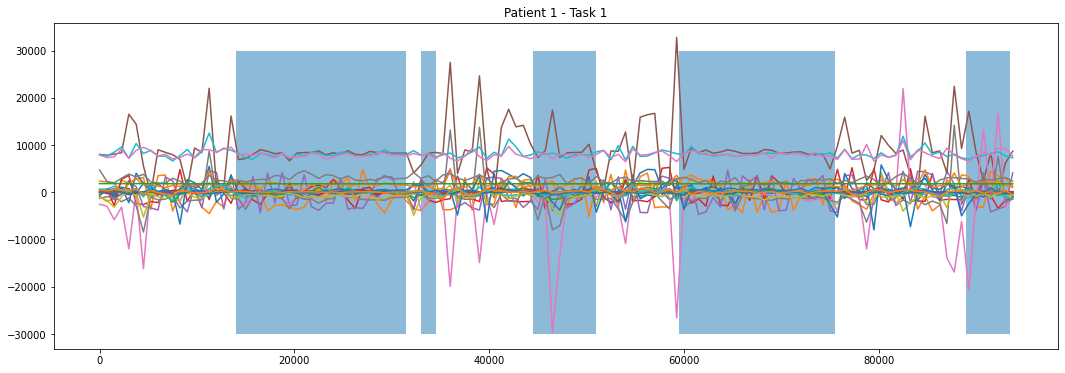

In [ ]:
# plt.figure(figsize=(18, 6))
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title('Patient 1 - Task 1')

step=750
columns = ['LTA', 'RTA', 'IO', 'ECG', 'RGS', 'accel_x1', 'accel_y1', 'accel_z1', 'gyro_x1', 'gyro_y1', 'gyro_z1', 'NC1', 'accel_x2', 'accel_y2', 'accel_z2', 'gyro_x2', 'gyro_y2', 'gyro_z2', 'NC2', 'accel_x3', 'accel_y3', 'accel_z3', 'gyro_x3', 'gyro_y3', 'gyro_z3', 'NC3', 'accel_x4', 'accel_y4', 'accel_z4', 'gyro_x4', 'gyro_y4', 'gyro_z4', 'SC']
for col in columns:
  ax.plot(task1[col][::step])
for i,loc in enumerate(changes): 
  if (i % 2) == 0:
    rect=patches.Rectangle((loc,-30000),changes[i+1]-loc,60000,alpha=0.5)
    ax.add_patch(rect)
  

In [ ]:
FX=np.array([X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12])
y=np.array([Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10,Y11,Y12])

In [ ]:
X=np.array([X1,X2,X3,X4,X5,X6])
y=np.array([Y1,Y2,Y3,Y4,Y5,Y6])

In [ ]:
X.shape, y.shape

((6, 94000, 33), (6, 94000))

In [ ]:
# X = X[:, 0]
# y = y.reshape(-1, 1)
# data = np.concatenate((X, y), axis=-1)
# df = pd.DataFrame(data)
# df.head()

In [ ]:
# X, y = df2xy(df, target_col='target')
# test_eq(X.shape, (60, 1, 570))
# test_eq(y.shape, (60, ))

In [ ]:
# splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=True)
# splits

In [ ]:
# X, y = df2xy(df, target_col='target')
# print(X.shape)
# test_eq(X.shape, (60, 1, 570))
# test_eq(y.shape, (60, ))



In [ ]:
# X_memmap=np.memmap(self._prepared_data_location_npmemmap_X,dtype='float32',mode='w+')
# X_list_total_standardized_memmap[:]=X_list_total_standardized[:]

